# Neural Agent Memory Analysis

This notebook analyzes the training memory of a neural agent to understand its performance and behavior over time. It loads the agent's memory, calculates win rates, and visualizes action distributions.

In [1]:
# Import necessary libraries
from pathlib import Path
import pickle
import numpy as np
from typing import List, Tuple

# Assuming src is in the python path or adjust sys.path if needed
import sys
sys.path.append('../') # Example if running from notebooks dir

from src.engine.actions import Action
from src.analysis.memory_analyzer import analyze_win_loss_and_steps, calculate_win_rate_over_time, analyze_and_plot_win_rates_by_starting_position

In [2]:
from src.analysis.memory_loader import load_memory
from src.analysis.action_analyzer import analyze_actions
from src.analysis.visualization import plot_win_rate_and_epsilon

# Get the user's home directory
home_dir = Path.home()

# Construct the path to the Downloads folder (or wherever your memory file is)
downloads_dir = home_dir / "Downloads"
# Define the path to the memory file
memory_file = downloads_dir / "memory_5000.pkl"

# Load the memory
agent_memory = load_memory(memory_file)

Successfully loaded 423 episodes from C:\Users\timmie\Downloads\memory_5000.pkl.


In [3]:
# Analyze actions
if agent_memory:
    action_type_counts, card_action_counts, card_name_to_obj, total_actions_processed, invalid_action_formats = analyze_actions(agent_memory)

    print("\n--- Action Analysis Report ---")
    print(f"Total actions processed: {total_actions_processed}")
    if invalid_action_formats > 0:
        print(f"Warning: Encountered {invalid_action_formats} invalid actions.")

    print("\n1. Overall Action Type Distribution:")
    for action_type, count in action_type_counts.items():
        print(f"- {action_type}: {count}")

    print("\n2. Detailed Card Action Distribution:")
    for (action_type, card_name), count in card_action_counts.items():
        print(f"- {action_type} - {card_name}: {count}")


--- Action Analysis Report ---
Total actions processed: 56505

1. Overall Action Type Distribution:
- ActionType.PLAY_CARD: 35365
- ActionType.ATTACK_PLAYER: 7309
- ActionType.BUY_CARD: 4902
- ActionType.END_TURN: 7100
- ActionType.DISCARD_CARDS: 378
- ActionType.SCRAP_CARD: 347
- ActionType.APPLY_EFFECT: 684
- ActionType.ATTACK_BASE: 228
- ActionType.SKIP_DECISION: 180
- ActionType.DESTROY_BASE: 12

2. Detailed Card Action Distribution:
- ActionType.PLAY_CARD - Scout: 20510
- ActionType.PLAY_CARD - Viper: 5117
- ActionType.BUY_CARD - Cutter: 245
- ActionType.BUY_CARD - Trading Post: 123
- ActionType.BUY_CARD - Trade Pod: 253
- ActionType.BUY_CARD - Missile Bot: 162
- ActionType.PLAY_CARD - Trade Pod: 759
- ActionType.PLAY_CARD - Cutter: 695
- ActionType.BUY_CARD - Freighter: 146
- ActionType.BUY_CARD - Blob Wheel: 250
- ActionType.PLAY_CARD - Trading Post: 113
- ActionType.BUY_CARD - Corvette: 116
- ActionType.BUY_CARD - Imperial Fighter: 228
- ActionType.BUY_CARD - Battle Pod: 168
-

Analyzed 423 completed episodes for outcomes and steps.
First player episodes: 226, Second player episodes: 197
Total actions analyzed: 56505
Analyzed 423 completed episodes for outcomes and steps.
First player episodes: 226, Second player episodes: 197
Total actions analyzed: 56505
Overall win rate (latest 50 episodes): 59.81% over 423 episodes
Win rate when agent starts first (latest chunk): 56.64% over 226 episodes
Win rate when agent starts second (latest chunk): 63.45% over 197 episodes


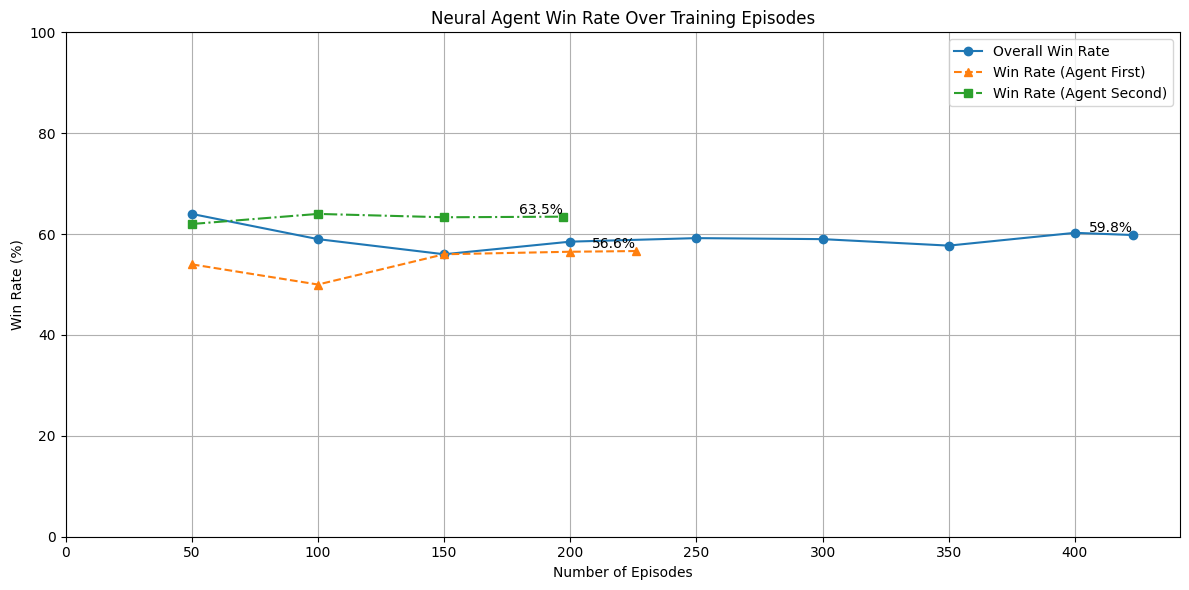

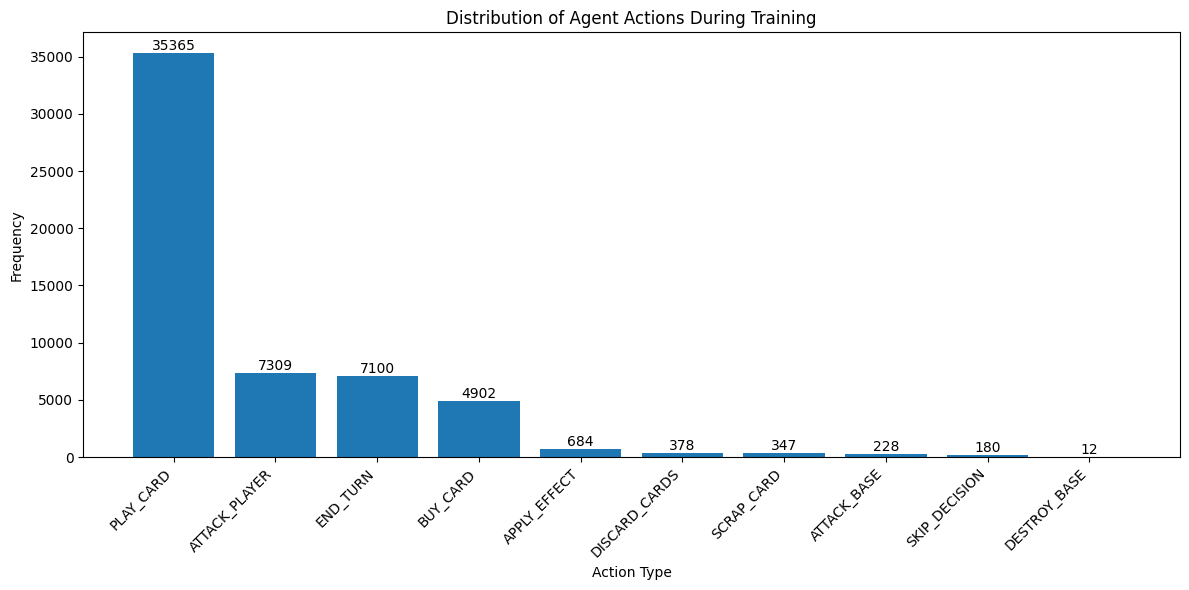

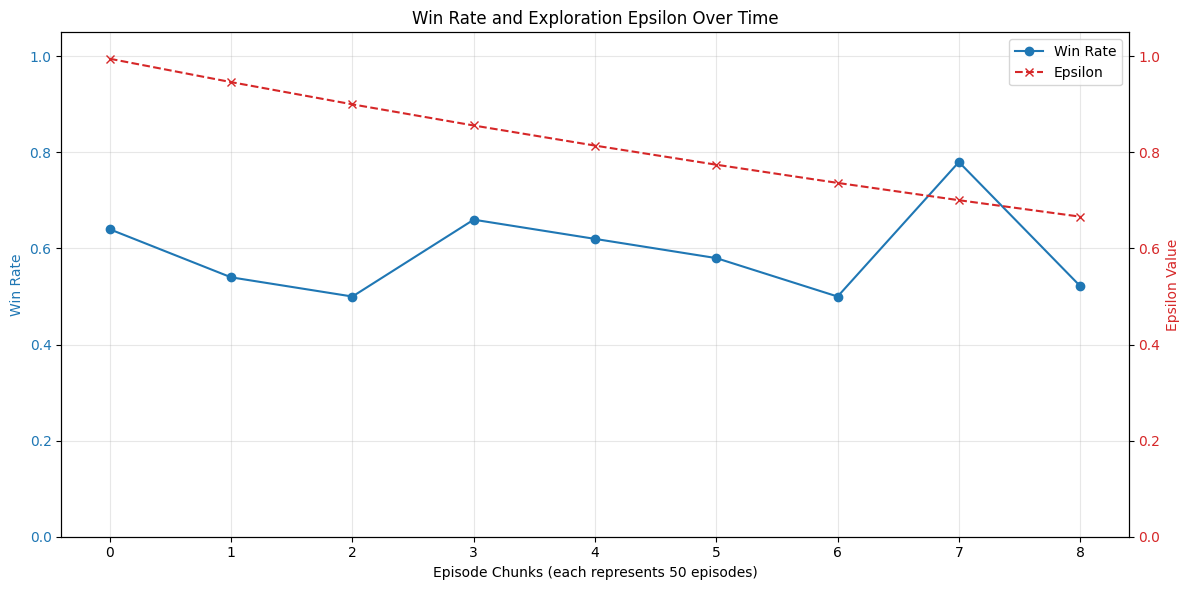


--- Analysis Summary ---
Total valid episodes analyzed: 423
Overall Win Rate: 59.81%
Average steps per episode: 133.58
Median steps per episode: 128.0
Min steps per episode: 73
Max steps per episode: 348

--- Action Distribution ---
Total actions taken across all episodes: 56505
- PLAY_CARD: 35365 (62.59%)
- ATTACK_PLAYER: 7309 (12.94%)
- END_TURN: 7100 (12.57%)
- BUY_CARD: 4902 (8.68%)
- APPLY_EFFECT: 684 (1.21%)
- DISCARD_CARDS: 378 (0.67%)
- SCRAP_CARD: 347 (0.61%)
- ATTACK_BASE: 228 (0.40%)
- SKIP_DECISION: 180 (0.32%)
- DESTROY_BASE: 12 (0.02%)
------------------------


In [5]:
if agent_memory:
    # Analyze win/loss outcomes, steps per episode, and action counts
    episode_outcomes, first_player_outcomes, second_player_outcomes, episode_steps, action_distribution = analyze_win_loss_and_steps(agent_memory)

    if episode_outcomes:
        # Calculate win rate over time (e.g., in chunks of 100 episodes)
        chunk_size = 50
        chunks, rates = calculate_win_rate_over_time(episode_outcomes, chunk_size)

        # Plot win rates by starting position (using existing function)
        analyze_and_plot_win_rates_by_starting_position(memory=agent_memory, chunk_size=chunk_size)
        
        # Plot win rate with exploration epsilon (using our new function)
        # Epsilon parameters: starts at 0.995 and decays every 5 episodes
        plot_win_rate_and_epsilon(episode_outcomes, 
                                 chunk_size=chunk_size, 
                                 initial_epsilon=0.995, 
                                 decay_interval=5)

        # Print overall summary
        overall_win_rate = np.mean(episode_outcomes) * 100
        print(f"\n--- Analysis Summary ---")
        print(f"Total valid episodes analyzed: {len(episode_outcomes)}")
        print(f"Overall Win Rate: {overall_win_rate:.2f}%")

        # Calculate and print step statistics
        if episode_steps:
            avg_steps = np.mean(episode_steps)
            median_steps = np.median(episode_steps)
            min_steps = np.min(episode_steps)
            max_steps = np.max(episode_steps)
            print(f"Average steps per episode: {avg_steps:.2f}")
            print(f"Median steps per episode: {median_steps}")
            print(f"Min steps per episode: {min_steps}")
            print(f"Max steps per episode: {max_steps}")
        else:
            print("No step data available for completed episodes.")

        # Print action distribution summary
        print("\n--- Action Distribution ---")
        if action_distribution:
            total_actions = sum(action_distribution.values())
            print(f"Total actions taken across all episodes: {total_actions}")
            # Sort actions by count for display
            sorted_actions = sorted(action_distribution.items(), key=lambda item: item[1], reverse=True)
            for action_type, count in sorted_actions:
                percentage = (count / total_actions) * 100 if total_actions > 0 else 0
                # Use ActionType.name if available
                action_name = action_type.name if hasattr(action_type, 'name') else str(action_type)
                print(f"- {action_name}: {count} ({percentage:.2f}%)")
        else:
            print("No action data recorded.")
        print(f"------------------------")

    else:
        print("No valid episode outcomes found to calculate statistics.")
else:
    print("Could not load memory or memory is empty.")
